<a href="https://colab.research.google.com/github/balcomes/keras-autoencoders/blob/master/train_conv_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# import the necessary packages
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import numpy as np

class ConvAutoencoder:
	@staticmethod
	def build(width, height, depth, filters=(32, 64), latentDim=16):
		# initialize the input shape to be "channels last" along with
		# the channels dimension itself
		# channels dimension itself
		inputShape = (height, width, depth)
		chanDim = -1

		# define the input to the encoder
		inputs = Input(shape=inputShape)
		x = inputs

		# loop over the number of filters
		for f in filters:
			# apply a CONV => RELU => BN operation
			x = Conv2D(f, (3, 3), strides=2, padding="same")(x)
			x = LeakyReLU(alpha=0.2)(x)
			x = BatchNormalization(axis=chanDim)(x)

		# flatten the network and then construct our latent vector
		volumeSize = K.int_shape(x)
		x = Flatten()(x)
		latent = Dense(latentDim)(x)

		# build the encoder model
		encoder = Model(inputs, latent, name="encoder")

		# start building the decoder model which will accept the
		# output of the encoder as its inputs
		latentInputs = Input(shape=(latentDim,))
		x = Dense(np.prod(volumeSize[1:]))(latentInputs)
		x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)

		# loop over our number of filters again, but this time in
		# reverse order
		for f in filters[::-1]:
			# apply a CONV_TRANSPOSE => RELU => BN operation
			x = Conv2DTranspose(f, (3, 3), strides=2,
				padding="same")(x)
			x = LeakyReLU(alpha=0.2)(x)
			x = BatchNormalization(axis=chanDim)(x)

		# apply a single CONV_TRANSPOSE layer used to recover the
		# original depth of the image
		x = Conv2DTranspose(depth, (3, 3), padding="same")(x)
		outputs = Activation("sigmoid")(x)

		# build the decoder model
		decoder = Model(latentInputs, outputs, name="decoder")

		# our autoencoder is the encoder + decoder
		autoencoder = Model(inputs, decoder(encoder(inputs)),
			name="autoencoder")

		# return a 3-tuple of the encoder, decoder, and autoencoder
		return (encoder, decoder, autoencoder)

In [4]:
# USAGE
# python train_conv_autoencoder.py

# set the matplotlib backend so figures can be saved in the background
import matplotlib
matplotlib.use("Agg")

# import the necessary packages
#from pyimagesearch.convautoencoder import ConvAutoencoder
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2

# construct the argument parse and parse the arguments
#ap = argparse.ArgumentParser()
#ap.add_argument("-s", "--samples", type=int, default=8,
#	help="# number of samples to visualize when decoding")
#ap.add_argument("-o", "--output", type=str, default="output.png",
#	help="path to output visualization file")
#ap.add_argument("-p", "--plot", type=str, default="plot.png",
#	help="path to output plot file")
#args = vars(ap.parse_args())

# initialize the number of epochs to train for and batch size
EPOCHS = 1
BS = 32

# load the MNIST dataset
print("[INFO] loading MNIST dataset...")
((trainX, _), (testX, _)) = mnist.load_data()

# add a channel dimension to every image in the dataset, then scale
# the pixel intensities to the range [0, 1]
trainX = np.expand_dims(trainX, axis=-1)
testX = np.expand_dims(testX, axis=-1)
trainX = trainX.astype("float32") / 255.0
testX = testX.astype("float32") / 255.0

# construct our convolutional autoencoder
print("[INFO] building autoencoder...")
(encoder, decoder, autoencoder) = ConvAutoencoder.build(28, 28, 1)
opt = Adam(lr=1e-3)
autoencoder.compile(loss="mse", optimizer=opt)

# train the convolutional autoencoder
H = autoencoder.fit(
	trainX, trainX,
	validation_data=(testX, testX),
	epochs=EPOCHS,
	batch_size=BS)

# construct a plot that plots and saves the training history
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
#plt.savefig(args["plot"])

# use the convolutional autoencoder to make predictions on the
# testing images, then initialize our list of output images
print("[INFO] making predictions...")
decoded = autoencoder.predict(testX)
outputs = None

# loop over our number of output samples
#for i in range(0, args["samples"]):
	# grab the original image and reconstructed image
#	original = (testX[i] * 255).astype("uint8")
#	recon = (decoded[i] * 255).astype("uint8")

	# stack the original and reconstructed image side-by-side
	#output = np.hstack([original, recon])

	# if the outputs array is empty, initialize it as the current
	# side-by-side image display
	#if outputs is None:
	#	outputs = output

	# otherwise, vertically stack the outputs
	#else:
	#	outputs = np.vstack([outputs, output])

# save the outputs image to disk
#cv2.imwrite(args["output"], outputs)

[INFO] loading MNIST dataset...
[INFO] building autoencoder...
Train on 60000 samples, validate on 10000 samples
60000/60000 [==============================] - 186s 3ms/sample - loss: 0.0185 - val_loss: 0.0106
[INFO] making predictions...


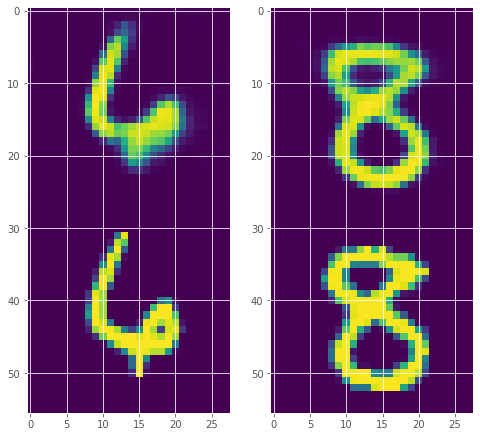

In [75]:
%matplotlib inline
import numpy as np

fig=plt.figure(figsize=(8, 8))
columns = 2
rows = 1
for i in range(1, columns*rows + 1):
    k = np.random.randint(0,10000)
    img = np.vstack([decoded[k,:,:,0], testX[k,:,:,0]])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

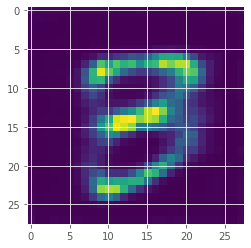

In [110]:
plt.imshow(autoencoder.predict(np.asarray(np.random.random(28*28).reshape([1,28,28,1])))[0,:,:,0])

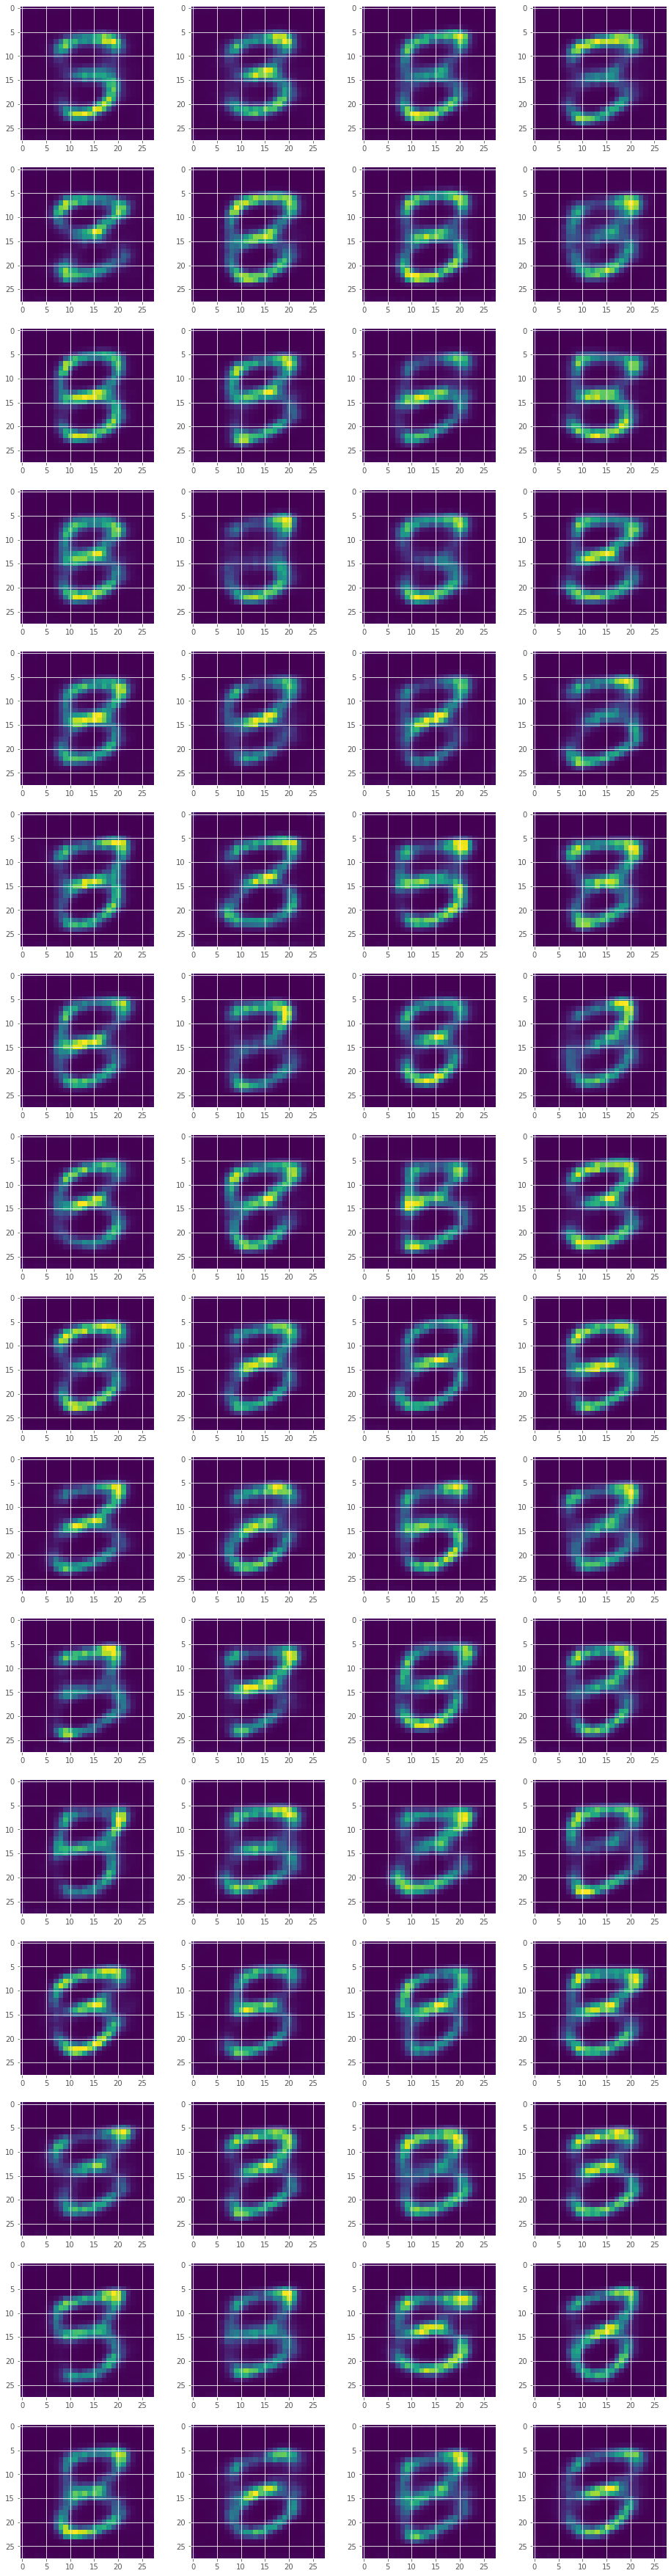

In [120]:
fig=plt.figure(figsize=(16, 64))
columns = 4
rows = 16
for i in range(1, columns*rows + 1):
    img = autoencoder.predict(np.asarray(np.random.random(28*28).reshape([1,28,28,1])))[0,:,:,0]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

In [0]:
#!tf_upgrade_v2 \
#  --intree my_project/ \
#  --outtree my_project_v2/ \
#  --reportfile report.txt

In [0]:
import imageio

In [0]:
dwarves = imageio.imread('dwarves.png')

In [360]:
dwarves.shape

(352, 192, 3)

In [0]:
tiles = np.expand_dims(dwarves, axis=-1)
tiles = tiles.astype("float32") / 255.0
tiles_r = tiles[:,:, 0, :]
tiles_g = tiles[:,:, 1, :]
tiles_b = tiles[:,:, 2, :]

In [0]:
M = 16
N = 16

tiles_r = np.asarray(tiles_r)
tiles_g = np.asarray(tiles_g)
tiles_b = np.asarray(tiles_b)


tiles_r = [tiles_r[x:x+M,y:y+N] for x in range(0,tiles_r.shape[0],M) for y in range(0,tiles_r.shape[1],N)]
tiles_g = [tiles_g[x:x+M,y:y+N] for x in range(0,tiles_g.shape[0],M) for y in range(0,tiles_g.shape[1],N)]
tiles_b = [tiles_b[x:x+M,y:y+N] for x in range(0,tiles_b.shape[0],M) for y in range(0,tiles_b.shape[1],N)]

tiles_r = np.asarray(tiles_r)
tiles_g = np.asarray(tiles_g)
tiles_b = np.asarray(tiles_b)

In [363]:
tiles_r.shape

(264, 16, 16, 1)

In [0]:
trainX = tiles_r

In [366]:
EPOCHS = 25
BS = 32

# construct our convolutional autoencoder
print("[INFO] building autoencoder...")
(encoder, decoder, autoencoder) = ConvAutoencoder.build(16, 16, 1)
opt = Adam(lr=1e-3)
autoencoder.compile(loss="mse", optimizer=opt)

# train the convolutional autoencoder
H = autoencoder.fit(
	trainX, trainX,
	epochs=EPOCHS,
	batch_size=BS)

[INFO] building autoencoder...
Train on 264 samples
Epoch 1/25
264/264 [==============================] - 3s 11ms/sample - loss: 0.0916
Epoch 2/25
264/264 [==============================] - 0s 1ms/sample - loss: 0.0562
Epoch 3/25
264/264 [==============================] - 0s 1ms/sample - loss: 0.0478
Epoch 4/25
264/264 [==============================] - 0s 1ms/sample - loss: 0.0418
Epoch 5/25
264/264 [==============================] - 0s 1ms/sample - loss: 0.0381
Epoch 6/25
264/264 [==============================] - 0s 1ms/sample - loss: 0.0346
Epoch 7/25
264/264 [==============================] - 0s 1ms/sample - loss: 0.0323
Epoch 8/25
264/264 [==============================] - 0s 1ms/sample - loss: 0.0299
Epoch 9/25
264/264 [==============================] - 0s 1ms/sample - loss: 0.0276
Epoch 10/25
264/264 [==============================] - 0s 1ms/sample - loss: 0.0259
Epoch 11/25
264/264 [==============================] - 0s 1ms/sample - loss: 0.0241
Epoch 12/25
264/264 [===========

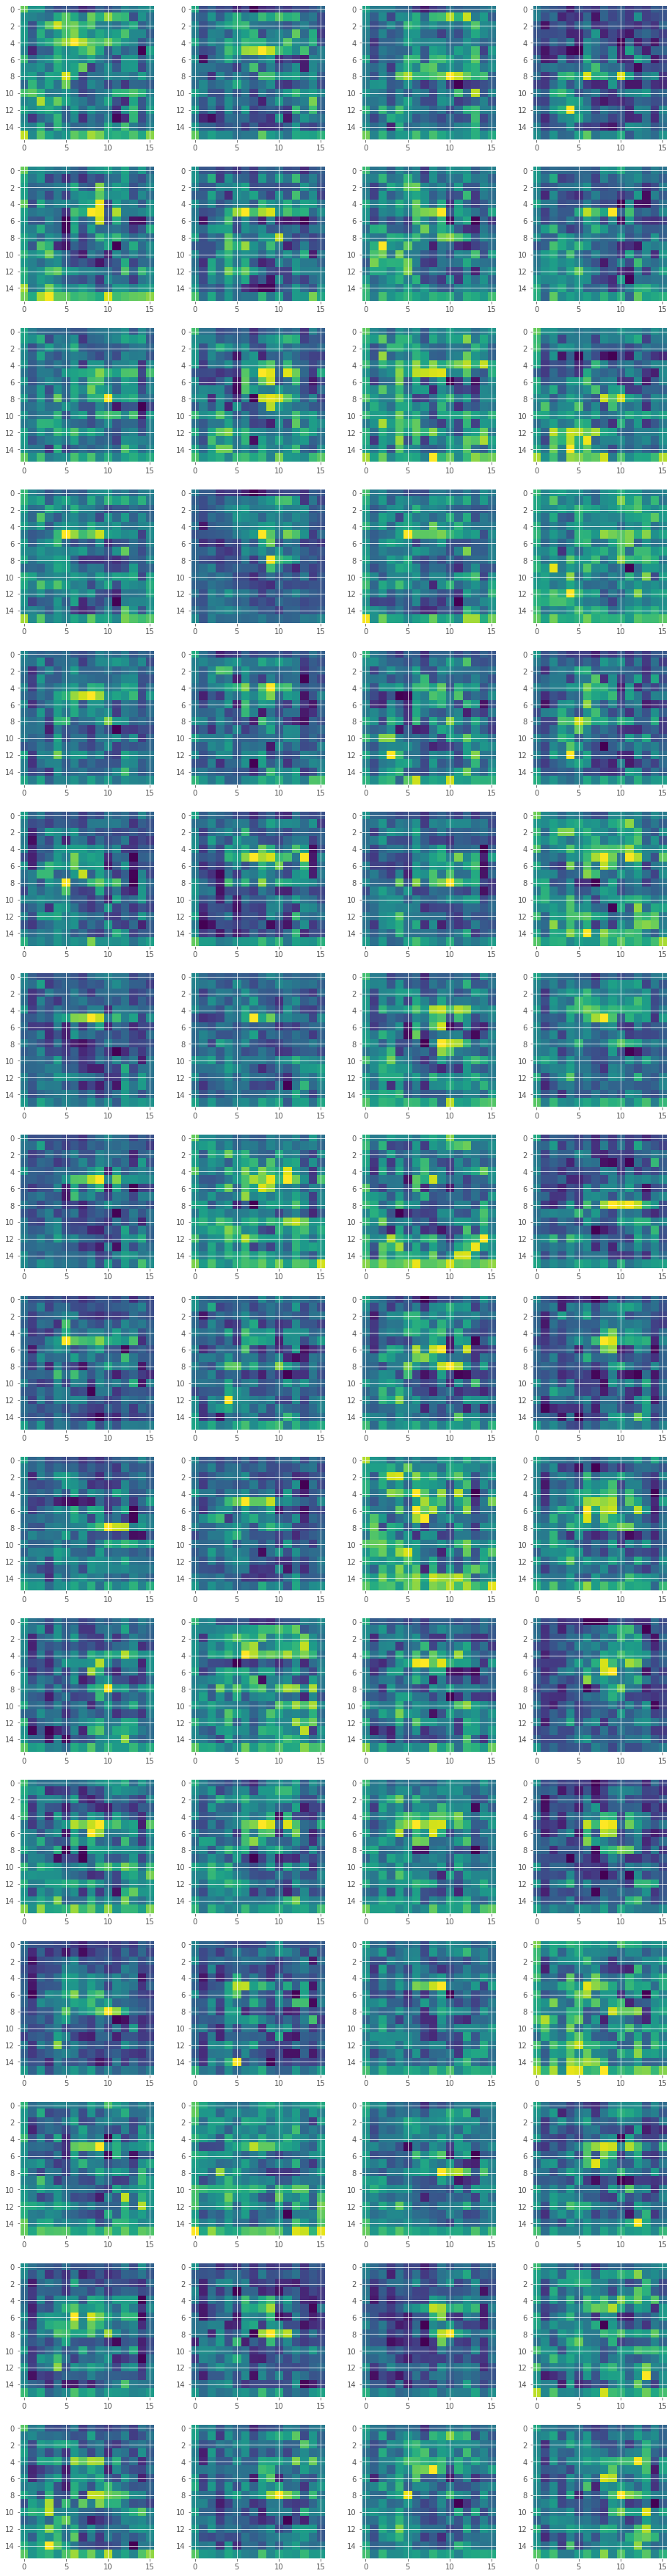

In [367]:
fig=plt.figure(figsize=(16, 64))
columns = 4
rows = 16
for i in range(1, columns*rows + 1):
    img = autoencoder.predict(np.asarray(np.random.random(16*16).reshape([1,16,16,1])))[0,:,:,0]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

In [0]:
def rgb_to_hex(rgb):
    return '%02x%02x%02x' % rgb

def hex_to_rgb(value):
    value = value.lstrip('#')
    lv = len(value)
    return tuple(int(value[i:i+lv//3], 16) for i in range(0, lv, lv//3))

In [0]:
hex_to_rgb(rgb_to_hex((255, 255, 195)))

In [0]:
from ast import literal_eval 
  
hex = rgb_to_hex((255, 255, 195))
print(hex)
literal_eval("0x" + str(hex))

In [253]:
trainX.shape

(60000, 28, 28, 1)

In [274]:
np.array([x for x in (tiles[:, :, :, 0:3, :]*255)]).shape

(264, 16, 16, 3, 1)

In [275]:
tiles.shape

(264, 16, 16, 3, 1)

In [0]:
tiles_h = [rgb_to_hex((int(x[0]*255),int(x[1]*255),int(x[2]*255))) for x in tiles[:, :, :, 0:3, :].reshape(264*16*16,3)]

In [0]:
tiles_dec = [literal_eval("0x" + str(x)) for x in tiles_h]

In [0]:
from sklearn import preprocessing
tiles_pp = preprocessing.normalize(np.asarray(tiles_dec).reshape(1,-1))

In [0]:
trainX_r = tiles_r
trainX_g = tiles_g
trainX_b = tiles_b

In [371]:
EPOCHS = 25
BS = 32



# construct our convolutional autoencoder
print("[INFO] building autoencoder...")
(encoder_r, decoder_r, autoencoder_r) = ConvAutoencoder.build(16, 16, 1)
opt = Adam(lr=1e-3)
autoencoder_r.compile(loss="mse", optimizer=opt)

# train the convolutional autoencoder
H = autoencoder_r.fit(
	trainX_r, trainX_r,
	epochs=EPOCHS,
	batch_size=BS)




# construct our convolutional autoencoder
print("[INFO] building autoencoder...")
(encoder_g, decoder_g, autoencoder_g) = ConvAutoencoder.build(16, 16, 1)
opt = Adam(lr=1e-3)
autoencoder_g.compile(loss="mse", optimizer=opt)

# train the convolutional autoencoder
H = autoencoder_g.fit(
	trainX_g, trainX_g,
	epochs=EPOCHS,
	batch_size=BS)




# construct our convolutional autoencoder
print("[INFO] building autoencoder...")
(encoder_b, decoder_b, autoencoder_b) = ConvAutoencoder.build(16, 16, 1)
opt = Adam(lr=1e-3)
autoencoder_b.compile(loss="mse", optimizer=opt)

# train the convolutional autoencoder
H = autoencoder_b.fit(
	trainX_b, trainX_b,
	epochs=EPOCHS,
	batch_size=BS)




[INFO] building autoencoder...
Train on 264 samples
Epoch 1/25
264/264 [==============================] - 3s 11ms/sample - loss: 0.1021
Epoch 2/25
264/264 [==============================] - 0s 1ms/sample - loss: 0.0554
Epoch 3/25
264/264 [==============================] - 0s 1ms/sample - loss: 0.0454
Epoch 4/25
264/264 [==============================] - 0s 1ms/sample - loss: 0.0395
Epoch 5/25
264/264 [==============================] - 0s 1ms/sample - loss: 0.0367
Epoch 6/25
264/264 [==============================] - 0s 1ms/sample - loss: 0.0330
Epoch 7/25
264/264 [==============================] - 0s 1ms/sample - loss: 0.0298
Epoch 8/25
264/264 [==============================] - 0s 1ms/sample - loss: 0.0283
Epoch 9/25
264/264 [==============================] - 0s 1ms/sample - loss: 0.0260
Epoch 10/25
264/264 [==============================] - 0s 1ms/sample - loss: 0.0242
Epoch 11/25
264/264 [==============================] - 0s 1ms/sample - loss: 0.0231
Epoch 12/25
264/264 [===========

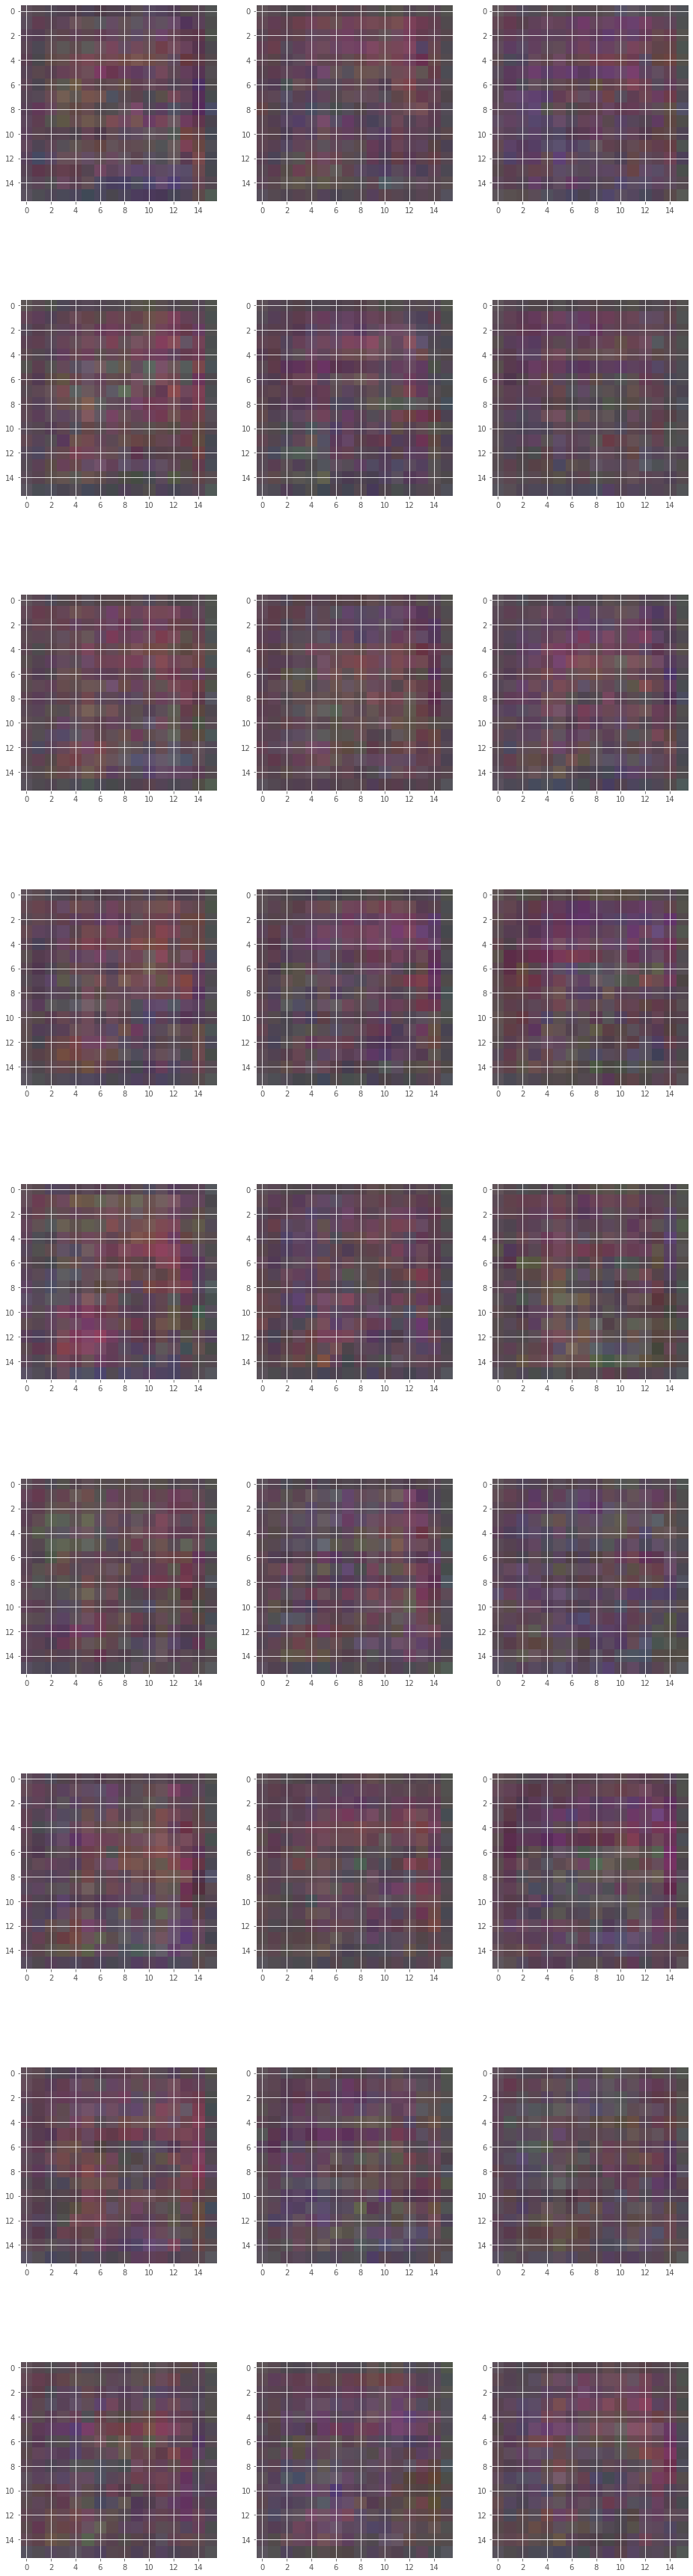

In [372]:
fig=plt.figure(figsize=(16, 64))
columns = 3
rows = 9
for i in range(1, columns*rows + 1):
    img_r = autoencoder_r.predict(np.asarray(np.random.random(16*16).reshape([1,16,16,1])))[0,:,:,0]
    img_g = autoencoder_g.predict(np.asarray(np.random.random(16*16).reshape([1,16,16,1])))[0,:,:,0]
    img_b = autoencoder_b.predict(np.asarray(np.random.random(16*16).reshape([1,16,16,1])))[0,:,:,0]
    img_rgb = np.dstack((img_r,img_g,img_b))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img_rgb)
plt.show()